In [ ]:
from PIL import Image
import numpy as np

def generate():
    for index, row in df.iterrows():
        image = read_and_resize(row['filepath'])
        yield image, row['gender']

def read_and_resize(filepath, input_shape=(299, 299)):
    im = Image.open((filepath)).convert('RGB')
    im = im.resize(input_shape)
    im_array = np.array(im, dtype="uint8")#[..., ::-1]
    return np.array(im_array / (np.max(im_array)+ 0.001), dtype="float32")

In [ ]:
import matplotlib.pyplot as plt

i = 1
for image, gender in generate():
    plt.imshow(image)
    print(gender)
    i -= 1
    if i == 0:
        break

In [ ]:
from tensorflow.keras import models

# Load partially trained model
model = models.load_model("/content/models/02"

In [ ]:
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)

print(test_acc)

# Setup

In [1]:
!nvidia-smi

Tue Nov 17 05:52:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf

# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_HEIGHT = 299
IMG_WIDTH = 299
BATCH_SIZE = 32
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)



---

### Load CelebA Dataset

In [ ]:
!unzip "/content/drive/My Drive/CZ4042/img_align_celeba.zip"

In [15]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('list_attr_celeba.txt', header=0, delim_whitespace=True)
df['filename'] = df.index
df['Male'] = df['Male'].astype(str)
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [16]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen_ca = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/img_align_celeba/',
                                                     x_col='image_id',
                                                     y_col='Male',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen_ca = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/img_align_celeba/',
                                                    x_col='image_id',
                                                    y_col='Male',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 162079 validated image filenames belonging to 2 classes.
Found 40520 validated image filenames belonging to 2 classes.




---

### Load Adience Dataset

In [6]:
!unzip "/content/drive/My Drive/CZ4042/aligned.zip"

Streaming output truncated to the last 5000 lines.
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.11502488145_87c4bb3b9d_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.11502488915_2f01dfed12_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.11695348323_d5f3db626d_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.11695384864_f86902d7f5_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.11695776546_1eb3bfe9e9_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.8157790892_33c7e51b81_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.8234642483_fa70653b87_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.8235732464_8309da3e26_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.8256030487_9e18b5e076_o.jpg  
  inflating: aligned/50739822@N00/landmark_aligned_face.1367.8257101128_0eaed12407_o.jpg  
  inflating: aligned/50739822@N00/

In [7]:
df = pd.DataFrame()
for i in range(0,5):
    df = pd.concat([df, pd.read_csv(f'fold_{i}_data.txt', sep='\t')])

In [8]:
from sklearn.model_selection import train_test_split

df = df[df['gender'].notna()]
df = df[df['age'] != 'None']
df.loc[df['age'] == '(27, 32)', 'age'] = '(25, 32)'
df.loc[df['age'] == '(38, 42)', 'age'] = '(38, 43)'
df.loc[df['age'] == '29', 'age'] = '(25, 32)'
df.loc[df['age'] == '2', 'age'] = '(0, 2)'
df.loc[df['age'] == '42', 'age'] = '(38, 43)'
df['age'].value_counts()
df = df[df.age.isin(['(0, 2)',
                     '(4, 6)',
                     '(8, 12)',
                     '(15, 20)',
                     '(25, 32)',
                     '(38, 43)',
                     '(48, 53)',
                     '(60, 100)'])]
df = df[df['gender'] != 'u']
df['filepath'] = df.apply(lambda row: row['user_id'] +
                          '/landmark_aligned_face.' + str(row['face_id']) + '.' +
                          row['original_image'],
         axis = 1
)
df = df.loc[:, ['filepath', 'age', 'gender']]

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

In [9]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='gender',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.
Found 3274 validated image filenames belonging to 2 classes.




---

## Benchmark

---



### ImageNet weights, no data augmentation

In [40]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

test_data_gen = image_generator.flow_from_dataframe(test_df,
                                                    directory='/content/aligned/',
                                                    x_col='filepath',
                                                    y_col='gender',
                                                    target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                    class_mode='categorical',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.
Found 3274 validated image filenames belonging to 2 classes.


In [17]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/models/{epoch:02d}',
                                                monitor='val_acc',
                                                mode="max")
log = tf.keras.callbacks.CSVLogger('/content/models/log.csv')
history = model.fit(train_data_gen,
                    epochs=10,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop, checkpoint, log],
                    verbose=1)

Epoch 1/10
410/410 [==============================] - 246s 600ms/step - loss: 0.3268 - accuracy: 0.8477 - val_loss: 0.1989 - val_accuracy: 0.9169
Epoch 2/10
410/410 [==============================] - 249s 608ms/step - loss: 0.1121 - accuracy: 0.9591 - val_loss: 0.1537 - val_accuracy: 0.9395
Epoch 3/10
410/410 [==============================] - 253s 618ms/step - loss: 0.0511 - accuracy: 0.9826 - val_loss: 0.1724 - val_accuracy: 0.9368
Epoch 4/10
410/410 [==============================] - 251s 613ms/step - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.1675 - val_accuracy: 0.9447
Epoch 5/10
410/410 [==============================] - 254s 619ms/step - loss: 0.0166 - accuracy: 0.9952 - val_loss: 0.1657 - val_accuracy: 0.9478
Epoch 6/10
410/410 [==============================] - 256s 625ms/step - loss: 0.0245 - accuracy: 0.9933 - val_loss: 0.2105 - val_accuracy: 0.9401
Epoch 7/10
410/410 [==============================] - 251s 613ms/step - loss: 0.0175 - accuracy: 0.9946 - val_loss: 0.1770 -

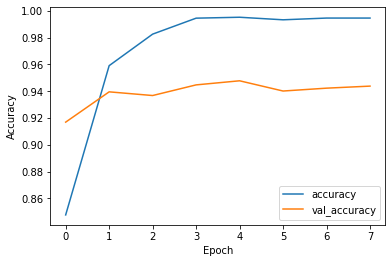

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

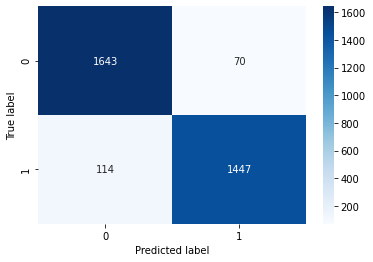

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ImageNet weights, Data augmentation

In [69]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=15,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  brightness_range=[0.9,1.1],
                                                                  zoom_range=[0.9,1.1],
                                                                  horizontal_flip=True,
                                                                  vertical_flip=False)
train_data_gen = image_generator.flow_from_dataframe(train_df,
                                                     directory='/content/aligned/',
                                                     x_col='filepath',
                                                     y_col='gender',
                                                     target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                     class_mode='categorical',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     seed=SEED)

Found 13092 validated image filenames belonging to 2 classes.


In [68]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=3)
history = model.fit(train_data_gen,
                    epochs=25,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/25
 13/410 [..............................] - ETA: 6:05 - loss: 0.6761 - accuracy: 0.5649

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(validation_data_gen, verbose=2)

print(test_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# No Pretrained Weights

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet',
                                               input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               pooling='avg')
model = tf.keras.models.Sequential(base_model)
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=3)
history = model.fit(train_data_gen,
                    epochs=100,
                    initial_epoch=0,
                    validation_data=test_data_gen,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/25
 13/410 [..............................] - ETA: 6:05 - loss: 0.6761 - accuracy: 0.5649

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
test_loss, test_acc = model.evaluate(validation_data_gen, verbose=2)

print(test_acc)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

model.add(tf.keras.layers.Softmax())
predict = model.predict(test_data_gen)
model.pop()

predict = np.argmax(predict, axis=1)

cm = confusion_matrix(test_data_gen.classes, predict)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()